# L'esempio di addestramento e uso di una semplice rete neurale per leggere cifre scritte a mano
Luca Mari, Dennis Remigio,  aggiornamento maggio 2024

[i file di questa attività: [mnist.ipynb](mnist.ipynb), [mnistutils.py](mnistutils.py)]

**Obiettivi**: comprendere la struttura di una semplice rete neurale, il suo addestramento e il suo funzionamento, per come specificati in Python mediante un modulo di alto livello come `PyTorch`.  
**Precompetenze**: basi di Python.

<a href="#s1">1. Il dataset</a>  
<a href="#s2">2. Prima opzione: un *MultiLayer Perceptron*</a>  
<a href="#s3">3. Un miglioramento del metodo di classificazione</a>  
<a href="#s4">4. Seconda opzione: una *Convolutional Neural Network*</a>

Per eseguire questo notebook, supponiamo con VSCode, occorre:
* installare un interprete Python
* scaricare da https://code.visualstudio.com/download e installare VSCode
* eseguire VSCode e attivare le estensioni per Python e Jupyter
* ancora in VSCode:
    * creare una cartella di lavoro e renderla la cartella corrente
    * copiare nella cartella questo notebook e aprirlo
    * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
    * installare i moduli Python richiesti, eseguendo dal terminale:  
        `pip install torch torchvision torchsummary numpy matplotlib`

<a name="s1"></a>
### 1. Il dataset

La rete che costruiremo dovrà imparare a riconoscere cifre scritte a mano, usando sia per l'addestramento sia per il funzionamento della rete [il dataset MNIST](https://en.wikipedia.org/wiki/MNIST_database), in cui ogni immagine, di 28x28 punti, contiene una cifra.

Dopo aver importato i moduli Python necessari, carichiamo le immagini del dataset MNIST, distinguendo tra training set e test set (la prima volta saranno scaricate dal web e copiate in una cartella locale).

In [1]:
from mnistutils import load_data, show_images, train_loop, test_loop, test_with_prob, test_loop_with_trace 

train_data, test_data = load_data()

print(f"Numero di immagini nel training set: {len(train_data)}")
print(f"Numero di immagini nel test set: {len(test_data)}")

Numero di immagini nel training set: 60000
Numero di immagini nel test set: 10000


In questo modo possiamo mostrare qualche esempio delle immagini che contengono le cifre che vogliamo addestrare la rete a riconoscere.

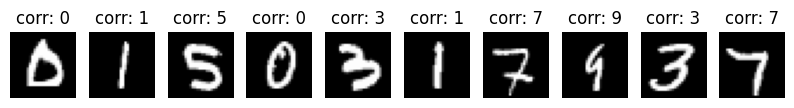

In [4]:
show_images(train_data)

La varietà e l'irregolarità di queste immagini suggeriscono che scrivere un programma "tradizionale", e dunque prima di tutto un algoritmo, potrebbe essere estremamente complesso. Cerchiamo dunque invece di risolvere il problema con la logica del *machine learning*, costruendo e poi addestrando una rete neurale artificiale.  
Lo faremo partendo da una rete con una struttura molto semplice (una rete *fully connected*, o *MultiLayer Perceptron*, MLP), per passare poi a una rete più complessa (una *Convolutional Neural Network*, CNN).

<a name="s2"></a>
### 2. Prima opzione: un *MultiLayer Perceptron*

Cominciamo a progettare la rete in accordo all'opzione più semplice, dunque come un *MultiLayer Perceptron*, definendo una classe che eredita da `torch.Module` e inizializzando gli strati (*layer*) della rete nel costruttore della classe:
* lo strato di input contiene 28*28 neuroni, dunque uno per ogni punto di un immagine, ognuno di essi connesso a ognuno dei neuroni del primo strato nascosto;
* il primo strato nascosto contiene 512 neuroni, ognuno di essi connesso a ognuno dei neuroni del secondo strato nascosto;
* il secondo strato nascosto contiene 512 neuroni, ognuno di essi connesso a ognuno dei neuroni dello strato di output;
* lo strato di output contiene 10 neuroni, uno per ogni possibile cifra riconoscibile.


Questa è dunque la struttura della rete:  

![rete](net.drawio.svg)

La classe implementa nel metodo `forward` le operazioni che compie sui dati di input.

Creiamo quindi la rete instanziando la classe. A questo punto i parametri della rete sono inizializzati come valori casuali.

In [6]:
import torch
from torch import nn

class MLP_NN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(   # Sequential() gestisce una successione di moduli
            nn.Linear(28*28, 512),      # Linear(x, y) è uno strato feed-forward fully connected con x input e y output
            nn.ReLU(),                  # ReLU() calcola la funzione di attivazione ReLu (rectified linear unit)
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = nn.Flatten()(x)             # Flatten() rende unidimensionale l'input, adattandolo così le immagini allo strato di input
        return self.network(x)
    
network = MLP_NN()

num_MLP_params = sum(p.numel() for p in network.parameters())
print(f"Questa è dunque una rete con {num_MLP_params} parametri.")

Questa è dunque una rete con 669706 parametri.


Possiamo chiedere una previsione a questa rete anche prima di addestrarla, ma ovviamente non ne otterremo nulla di utile, come si vede dal confronto tra la cifra prevista ("prev") e quella corretta ("corr") per un'immagine scelta a caso, in cui la cifra prevista è quella più probabile nella distribuzionee risultato dell'inferenza, cioè la moda della distribuzione. E infatti la distribuzione è praticamente uniforme, a indicare che la rete non è ancora in grado di riconoscere cifre.

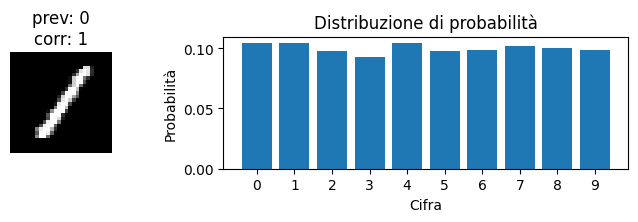

In [13]:
test_with_prob(test_data, network)

Specifichiamo allora come addestrare la rete, scegliendo gli iperparametri, la funzione di errore, e la funzione di ottimizzazione per la backpropagation.

In [14]:
learning_rate = 1e-3
batch_size = 50
num_batches = 500
epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

Addestriamo la rete in accordo a questi iperparametri e, contestualmente, mettiamola alla prova.

In [15]:
import time

start_time = time.time()
print("Epoca\tErrore\tAccuratezza")
for t in range(epochs):
    loss = train_loop(train_data, batch_size, num_batches, network, loss_fn, optimizer)
    correct = test_loop(test_data, batch_size, network)
    print(f"{t + 1}\t{loss:.3f}\t{100 * correct / batch_size:.1f}%")
end_time = time.time()

print(f"Processo completato, in {end_time - start_time:.2f} secondi")

Epoca	Errore	Accuratezza
1	2.285	30.0%
2	2.266	42.0%
3	2.211	50.0%
4	2.178	50.0%
5	2.128	66.0%
6	2.060	62.0%
7	1.965	74.0%
8	1.789	72.0%
9	1.674	76.0%
10	1.443	74.0%
11	1.418	72.0%
12	1.159	74.0%
13	1.073	70.0%
14	0.963	84.0%
15	0.807	78.0%
16	0.832	82.0%
17	0.732	84.0%
18	0.745	88.0%
19	0.568	94.0%
20	0.636	92.0%
Processo completato, in 34.26 secondi


A rete addestrata, valutiamo quantitativamente l'accuratezza delle previsioni che è in grado di fare.

In [22]:
batch_size = 1000
correct = test_loop(test_data, batch_size, network)
print(f"Accuratezza: {100*correct/batch_size:.1f}%")

Accuratezza: 88.7%


Valutiamo qualitativamente l'accuratezza delle previsioni, confrontando la cifra prevista ("prev") e quella corretta ("corr") per 10 immagini a caso.

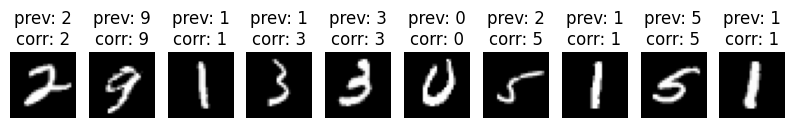

In [16]:
test_loop_with_trace(test_data, network)

Valutiamo il caso di una singola immagine, confrontando la cifra prevista ("prev") e quella corretta ("corr"), e visualizziamo la distribuzione di probabilità risultato dell'inferenza, da cui si sceglie la cifra prevista come quella più probabile.

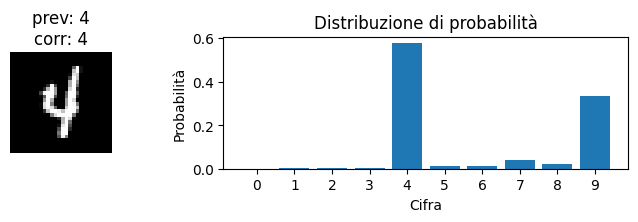

In [22]:
test_with_prob(test_data, network)

<a name="s3"></a>
### 3. Un miglioramento del metodo di classificazione

Ovviamente si potrebbe raffinare questo metodo di decisione, per esempio per non proporre alcuna previsione, e quindi dichiarare il caso dubbio, se la probabilità della moda non è abbastanza grande o la differenza fra le due probabilità più grandi della distribuzione non è abbastanza grande.

In [25]:

from torch.utils.data import DataLoader
network.eval()                              # metti in modalità di test
dataloader = iter(DataLoader(test_data, batch_size=batch_size, shuffle=True))   # crea un iteratore sul test set

with torch.no_grad():                       # non calcolare i gradienti
    X, y = next(dataloader)                 # prendi un batch di immagini ed etichette
    logits = network(X)                     # calcola le previsioni
pred_prob = nn.Softmax(dim=1)(logits)       # converti le previsioni in distribuzioni di probabilità

y_pred = pred_prob.argmax(1)
corr_pred = torch.eq(y_pred, y)
print("*** Risultati del test senza aggiustamento ***")
print(f"Accuratezza: {100 * corr_pred.sum().item() / batch_size:.1f}%")
print(f"Errore: {100 * (batch_size - corr_pred.sum().item()) / batch_size:.1f}%")

min_mode_prob = 0.3                         # probabilità minima per considerare una previsione corretta
min_diff_prob = 0.2                         # differenza minima tra le due probabilità più alte per considerare una previsione corretta
two_max_prob = torch.topk(pred_prob, 2).values
suff_high_prob = two_max_prob[:,0] > min_mode_prob
suff_diff_prob = (two_max_prob[:,0] - two_max_prob[:,1]) > min_diff_prob
suff_quality = suff_high_prob * suff_diff_prob
adj_corr_pred = corr_pred * suff_quality
doubtful_pred = torch.logical_not(suff_quality)
print("\n*** Risultati del test con aggiustamento ***")
print(f"(probabilità minima per considerare una previsione corretta: {min_mode_prob})")
print(f"(differenza minima tra le due probabilità più alte per considerare una previsione corretta: {min_diff_prob})")
print(f"Accuratezza: {100 * adj_corr_pred.sum().item() / batch_size:.1f}%")
print(f"Previsioni sospese perché dubbie: {100 * doubtful_pred.sum().item() / batch_size:.1f}%")
print(f"Errore: {100 * (suff_quality * torch.logical_not(corr_pred)).sum().item() / batch_size:.1f}%")

*** Risultati del test senza aggiustamento ***
Accuratezza: 89.9%
Errore: 10.1%

*** Risultati del test con aggiustamento ***
(probabilità minima per considerare una previsione corretta: 0.3)
(differenza minima tra le due probabilità più alte per considerare una previsione corretta: 0.2)
Accuratezza: 83.3%
Previsioni sospese perché dubbie: 12.0%
Errore: 4.7%


Come si vede, questo aggiustamento riduce l'accuratezza ma anche l'errore della previsione. Ecco qualche esempio.

Esempi di immagini per cui non si è sicuri della previsione:


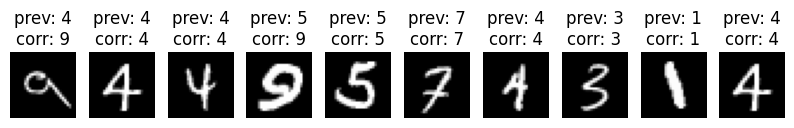

Esempi di immagini per cui la previsione è sbagliata:


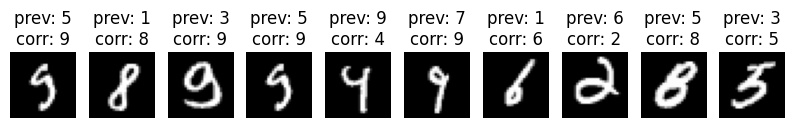

In [26]:
doubtful_data = [(X[i], y[i]) for i in range(batch_size) if doubtful_pred[i]]
print("Esempi di immagini per cui non si è sicuri della previsione:")
test_loop_with_trace(doubtful_data, network)

wrong_pred = [(X[i], y[i]) for i in range(batch_size) if (suff_quality * torch.logical_not(corr_pred))[i]]
print("Esempi di immagini per cui la previsione è sbagliata:")
test_loop_with_trace(wrong_pred, network)


Sebbene questa rete abbia prdotto previsioni abbastanza accurate, non è ideale per la classificazione di immagini. I *MultiLayer Perceptron* (MLP) richiedono infatti di trasformare le immagini su cui operare, che hanno una struttura bidimensionale, in successioni di valori unidimensionali, perdendo così l'informazione appunto sulla posizione relativa dei punti. In più, l'efficienza dei MLP diminuisce all'aumentare delle dimensioni delle immagini da analizzare, perché il numero di parametri del modello e quindi la capacità di calcolo necessaria per l'addestramento crescono significativamente con l'aumento di tali dimensioni.

<a name="s4"></a>
### 4. Seconda opzione: una *Convolutional Neural Network*

Per superare questi ostacoli, si usano tipicamente delle *Convolutional Neural Network* (CNN), che operano mantenendo l'informazione sulla disposizione spaziale dei punti delle immagini da classificare, in modo da apprenderne il contenuto in modo più efficace ed efficiente.

Realizziamo dunque una CNN, nuovamente come una classe che eredita da `torch.Module`, con questa successione di strati, inizializzati nel costruttore della classe:
* un primo strato convoluzionale, in cui:
    * 1 è il numero di canali di input, dato che si tratta di immagini in scala di grigi (per immagini RGB sarebbe 3);
    * 32: il numero di canali di output, cioè il numero di filtri convoluzionali dello strato, assumendo che ogni filtro estragga una caratteristica dall'immagine;
    * kernel_size=3 specifica che la dimensione del filtro è 3x3;
    * stride=1 specifica che il filtro si muove di 1 pixel alla volta durante la scansione dell'immagine;
    * padding=1 indica di aggiungere 1 pixel, di valore zero, attorno all'immagine per permettere al filtro di lavorare anche sui bordi dell'immagine, mantenendo la stessa dimensione dell'output come l'input;
    
    durante l'operazione di convoluzione, ciascuno dei 32 filtri si sposta attraverso l'immagine di input:
    * ogni filtro ha una griglia di pesi 3x3 che viene moltiplicata per i valori dei pixel corrispondenti dell'immagine sotto il filtro (più un bias);
    * questi prodotti sono sommati per ottenere un singolo valore di output per quella posizione specifica del filtro sull'immagine;
    * poiché il stride è 1 e il padding è 1, il filtro si sposta di un pixel alla volta e lavora su tutta l'area dell'immagine, inclusi i bordi, producendo un'immagine di output della stessa dimensione dell'immagine di input, ma con 32 canali differenti, uno per ogni filtro;

* una funzione di attivazione non lineare, in questo caso *Rectified Linear Unit* (ReLU), per introdurre non linearità nel processo di apprendimento;
* uno strato di *pooling* in cui:
    * kernel_size=2 specifica che il filtro è un quadrato 2x2;
    * stride=2 specifica che il filtro si muove di 2 pixel alla volta e quindi che ogni operazione di pooling è completamente non sovrapposta con la precedente, dimezzando così la dimensione dell'output;
* un secondo strato convoluzionale, ancora seguito da una funzione di ReLU e uno strato di pooling;
* la unidimensionalizzazione (*flatten*) della struttura;
* uno strato *fully connected* per ottenere i 10 output possibili della classificazione.






In [52]:
import torch
from torch import nn
import torch.nn.functional as F               

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)   # Convolutional Layer 1: prende 1 canale di input, produce 32 canali di output, kernel di 3x3
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                  # Max Pooling Layer 1: finestra di pooling 2x2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Convolutional Layer 2: prende 32 canali di input, produce 64 canali di output, kernel di 3x3
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                  # Max Pooling Layer 2: finestra di pooling 2x2
        self.fc = nn.Linear(64 * 7 * 7, 10)                                 # Fully connected layer: converte i canali di output del layer convoluzionale in classi


    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))            # Applica il primo layer convoluzionale, seguito da ReLU e max pooling
        x = self.pool2(F.relu(self.conv2(x)))           # Applica il secondo layer convoluzionale, seguito da ReLU e max pooling
        x = torch.flatten(x, 1)                             # Appiattisci l'output per passarlo al fully connected layer
        x = self.fc(x)                      # Applica il fully connected layer
        return x
     
network = CNN()

num_CNN_params = sum(p.numel() for p in network.parameters())
print(f"Questa è dunque una rete con {num_CNN_params} parametri, invece dei {num_MLP_params} della precedente.")

Questa è dunque una rete con 50186 parametri, invece dei 669706 della precedente.


Questa rete ha dunque un numero di parametri è un ordine di grandezza inferiore alla precedente. Per capire meglio la struttura della CNN, è interessante vedere come si giunge a questo numero di parametri:
* conv1 ha un kernel di dimensione 3x3, 1 canale di input e 32 canali di output; quindi per ciascun filtro ci sono 3×3×13×3×1 parametri, più un bias per ogni canale di output: (3×3×1+1)×32=320;
* conv2 Ha un kernel di dimensione 3x3, 32 canali di input e 64 canali di output; ci sono 3×3×323×3×32 pesi per filtro, più un bias per ogni canale di output: (3×3×32+1)×64=18496;
* fc: dopo i due strati di pooling con kernel 2x2 e stride 2, le dimensioni spaziali dell'input sono ridotte di un fattore di 4 (da 28x28 a 7x7); l'input ha perciò dimensioni 7x7 per ciascuno dei 64 canali di output di conv2, e ci sono 10 output: (7×7×64+1)×10=31370

Sommando tutti i parametri dei layer, otteniamo il numero totale di parametri della rete: 320+18496+31370=50186.

Per mettere alla prova questa rete rispetto alla precedente, addestriamola nelle stesse condizioni: stessi iperparametri, stessa funzione di errore, stessa funzione di ottimizzazione per la backpropagation.

In [53]:
learning_rate = 1e-3
batch_size = 50
num_batches = 500
epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

Addestriamo la rete in accordo a questi iperparametri e, contestualmente, mettiamola alla prova.

In [54]:
import time

start_time = time.time()
print("Epoca\tErrore\tAccuratezza")
for t in range(epochs):
    loss = train_loop(train_data, batch_size, num_batches, network, loss_fn, optimizer)
    correct = test_loop(test_data, batch_size, network)
    print(f"{t + 1}\t{loss:.3f}\t{100 * correct / batch_size:.1f}%")
end_time = time.time()

print(f"Processo completato, in {end_time - start_time:.2f} secondi")

Epoca	Errore	Accuratezza
1	2.236	54.0%
2	2.142	64.0%
3	1.897	76.0%
4	1.241	76.0%
5	0.884	84.0%
6	0.662	84.0%
7	0.344	92.0%
8	0.522	78.0%
9	0.570	90.0%
10	0.370	92.0%
11	0.269	88.0%
12	0.368	86.0%
13	0.171	96.0%
14	0.546	96.0%
15	0.208	84.0%
16	0.397	100.0%
17	0.381	88.0%
18	0.154	92.0%
19	0.341	88.0%
20	0.299	92.0%
Processo completato, in 78.22 secondi


Come si vede, nonostante il numero molto inferiore di parametri, la CNN ha un'accuratezza analoga o migliore di quella del MLP, ma richiede un tempo di addestramento più che doppio.

A rete addestrata, valutiamo quantitativamente l'accuratezza delle previsioni che è in grado di fare.

In [55]:
batch_size = 1000
correct = test_loop(test_data, batch_size, network)
print(f"Accuratezza: {100*correct/batch_size:.1f}%")

Accuratezza: 91.6%


Valutiamo qualitativamente l'accuratezza delle previsioni, confrontando la cifra prevista ("prev") e quella corretta ("corr") per 10 immagini a caso.

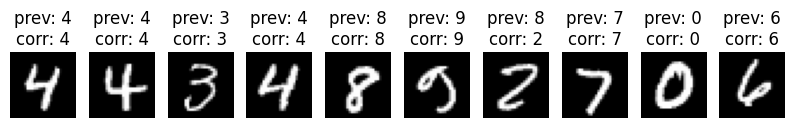

In [56]:
test_loop_with_trace(test_data, network)

Valutiamo il caso di una singola immagine, confrontando la cifra prevista ("prev") e quella corretta ("corr"), e visualizziamo la distribuzione di probabilità risultato dell'inferenza, da cui si sceglie la cifra prevista come quella più probabile.

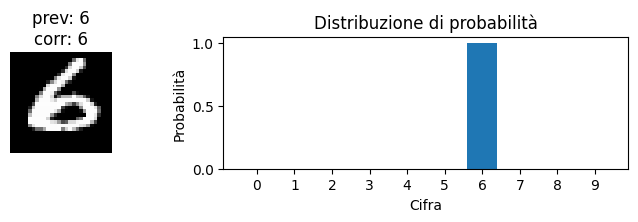

In [57]:
test_with_prob(test_data, network)

Ovviamente, come nel caso del MultiLayer Perceptron, anche questa rete convoluzionale potremmo raffinare variamente il metodo di decisione, invece di affidarci semplicemente alla scelta della cifra più probabile.